# Chicago Crime Data Analysis

In [ ]:
## Import necessary packages
import pandas as pd
import numpy as np
import folium
from folium import plugins
from folium.plugins import MarkerCluster
import seaborn as sns


import folium
from folium import plugins
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from yellowbrick.classifier import ClassificationReport

%matplotlib inline

In [ ]:
!pip install pyspark

In [ ]:
#spark imports
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
import csv
from pyspark.sql.types import *
from pyspark.sql.functions import format_number, when
import pyspark.sql.functions as F

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/Shareddrives/CIS 545- Final Project/

/content/gdrive/Shareddrives/CIS 545- Final Project


In [ ]:
from pyspark.sql import SparkSession

appName = "ChicagoCrime"

# Create Spark session
spark = SparkSession.builder.appName(appName).getOrCreate()

In [ ]:
#Defining schema for the dataset on spark
crimes_schema = StructType([StructField("ID", StringType(), True),
                            StructField("Case Number", StringType(), True),
                            StructField("Date", StringType(), True ),
                            StructField("Block", StringType(), True),
                            StructField("IUCR", StringType(), True),
                            StructField("Primary Type", StringType(), True  ),
                            StructField("Description", StringType(), True ),
                            StructField("Location Description", StringType(), True ),
                            StructField("Arrest", BooleanType(), True),
                            StructField("Domestic", BooleanType(), True),
                            StructField("Beat", StringType(), True),
                            StructField("District", StringType(), True),
                            StructField("Ward", StringType(), True),
                            StructField("Community Area", StringType(), True),
                            StructField("FBI Code", StringType(), True ),
                            StructField("X Coordinate", DoubleType(), True),
                            StructField("Y Coordinate", DoubleType(), True ),
                            StructField("Year", IntegerType(), True),
                            StructField("Updated On", DateType(), True ),
                            StructField("Latitude", DoubleType(), True),
                            StructField("Longitude", DoubleType(), True),
                            StructField("Location", StringType(), True )
                            ])

In [ ]:
dataset = spark.read.csv('Crimes_-_2001_to_Present.csv',header = True,schema = crimes_schema)

In [ ]:
dataset.columns

['ID',
 'Case Number',
 'Date',
 'Block',
 'IUCR',
 'Primary Type',
 'Description',
 'Location Description',
 'Arrest',
 'Domestic',
 'Beat',
 'District',
 'Ward',
 'Community Area',
 'FBI Code',
 'X Coordinate',
 'Y Coordinate',
 'Year',
 'Updated On',
 'Latitude',
 'Longitude',
 'Location']

Visualising the data

In [ ]:
dataset.show(5)

+--------+-----------+--------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------+------------+-------------+--------------------+
|      ID|Case Number|                Date|               Block|IUCR|Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+--------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------+------------+-------------+--------------------+
|10224738|   HY411648|09/05/2015 01:30:...|     043XX S WOOD ST|0486|     BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|0924|     009|  12|            61|    

In [ ]:
#number of rows
dataset.count()

7521407

In [ ]:
#filter dataset to have data from 2010- Present
dataset=dataset.filter((dataset['Year'] >2009))

In [ ]:
dataset.count()

3444472

## Section 1 : **Data** Cleaning 

### Handling Missing Values

In [ ]:
from pyspark.sql.functions import isnan, when, count, col
dataset.select([count(when(col(c).isNull(), c)).alias(c) for c in dataset.columns]).show()

+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------+--------+---------+--------+
| ID|Case Number|Date|Block|IUCR|Primary Type|Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|Updated On|Latitude|Longitude|Location|
+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------+--------+---------+--------+
|  0|          2|   0|    0|   0|           0|          0|                8966|     0|       0|   0|       1|  91|           398|       0|       32655|       32655|   0|   3444472|   32655|    32655|   32655|
+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+

The Updated On column doesn't have any information for all rows and it is not of relavance for us when it comes to analysis of crime, So we are dropping the column.

In [ ]:
dataset = dataset.drop('Updated On')

In [ ]:
dataset.columns

['ID',
 'Case Number',
 'Date',
 'Block',
 'IUCR',
 'Primary Type',
 'Description',
 'Location Description',
 'Arrest',
 'Domestic',
 'Beat',
 'District',
 'Ward',
 'Community Area',
 'FBI Code',
 'X Coordinate',
 'Y Coordinate',
 'Year',
 'Latitude',
 'Longitude',
 'Location']

In [ ]:
dataset.select([count(when(col(c).isNull(), c)).alias(c) for c in dataset.columns]).show()

+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------+---------+--------+
| ID|Case Number|Date|Block|IUCR|Primary Type|Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|Latitude|Longitude|Location|
+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------+---------+--------+
|  0|          2|   0|    0|   0|           0|          0|                8966|     0|       0|   0|       1|  91|           398|       0|       32655|       32655|   0|   32655|    32655|   32655|
+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------+---------+--------+



In [ ]:
dataset.show(5)

+--------+-----------+--------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+------------+-------------+--------------------+
|      ID|Case Number|                Date|               Block|IUCR|Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|    Latitude|    Longitude|            Location|
+--------+-----------+--------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+------------+-------------+--------------------+
|10224738|   HY411648|09/05/2015 01:30:...|     043XX S WOOD ST|0486|     BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|0924|     009|  12|            61|     08B|   1165074.0|   1875917.0|20

**How we handle missing values**

We can see that all the features that have missing values are mostly the features that relate to geographical location (example- X-coordinate, Y-coordinate, Latitude, Longitude, etc.) This is probably because the Chicago Crime dataset is mainly based on crimes reported by people involved in or around the crime. These reports don't always contain the exact location of the crime. 

The missing values in the whole dataset are present in Location Description, Ward, Community Area, X Coordinate, Y Coordinate, Updated On, Latitude, Longitude and Location.
These features are not direct numeric values, we can't use summary statistical functions to fill in the missing values.
So after deciding which columns to keep we shall be removing these values from the dataset.

In [ ]:
dataset=dataset.na.drop()

In [ ]:
dataset_size= dataset.count()
dataset_size

3405511

### Adding Hour, Day, Month columns to the dataset

In [ ]:
# converting the String Date column to timestamp object
from pyspark.sql.functions import *

dataset= dataset.withColumn("Date",to_timestamp(col("Date"),'MM/dd/yyyy hh:mm:ss a'))
dataset.show(5)

+--------+-----------+-------------------+-------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+------------+-------------+--------------------+
|      ID|Case Number|               Date|              Block|IUCR|Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+-------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+------------+-------------+--------------------+
|10224738|   HY411648|2015-09-05 13:30:00|    043XX S WOOD ST|0486|     BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|0924|     009|  12|            61|     08B|   1165074.0|   1875917.0|2015|41.81

In [ ]:
# Add Day of the Week Column
dataset = dataset.withColumn('Day',dayofweek(dataset.Date))
# Add Month Column
dataset = dataset.withColumn('Month',month(dataset.Date))
# Add Hour Column
dataset = dataset.withColumn('Hour', hour(dataset.Date))

dataset.show(5)

+--------+-----------+-------------------+-------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+------------+-------------+--------------------+---+-----+----+
|      ID|Case Number|               Date|              Block|IUCR|Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|    Latitude|    Longitude|            Location|Day|Month|Hour|
+--------+-----------+-------------------+-------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+------------+-------------+--------------------+---+-----+----+
|10224738|   HY411648|2015-09-05 13:30:00|    043XX S WOOD ST|0486|     BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|0924|     009|  12|            61|

## Section 2 : Exploratory Data Analysis

### (i) Most prevalent crimes in Chicago from 2010-2020

In [ ]:
prevalent_crimes = dataset.groupby('Primary Type').count().sort('count', ascending=False)
prevalent_crimes_df = prevalent_crimes.toPandas()

In [ ]:
prevalent_crimes_df

Primary Type   count
0                               THEFT  756841
1                             BATTERY  627119
2                     CRIMINAL DAMAGE  370326
3                           NARCOTICS  267033
4                             ASSAULT  235667
5                       OTHER OFFENSE  209373
6                            BURGLARY  187018
7                  DECEPTIVE PRACTICE  182826
8                 MOTOR VEHICLE THEFT  152587
9                             ROBBERY  132239
10                  CRIMINAL TRESPASS   83626
11                  WEAPONS VIOLATION   60409
12         OFFENSE INVOLVING CHILDREN   26713
13             PUBLIC PEACE VIOLATION   26063
14                       PROSTITUTION   15082
15                CRIM SEXUAL ASSAULT   13004
16   INTERFERENCE WITH PUBLIC OFFICER   12981
17                        SEX OFFENSE   12430
18                           HOMICIDE    7076
19                              ARSON    5607
20                           GAMBLING    4448
21               LIQUOR LAW VIOLATION    4349
22            CRIMINAL SEXUAL ASSAULT    4056
23                           STALKING    2431
24                         KIDNAPPING    2427
25                       INTIMIDATION    1819
26  CONCEALED CARRY LICENSE VIOLATION     885
27                          OBSCENITY     582
28                       NON-CRIMINAL     166
29                   PUBLIC INDECENCY     129
30                  HUMAN TRAFFICKING      83
31           OTHER NARCOTIC VIOLATION      68
32                     NON - CRIMINAL      38
33   NON-CRIMINAL (SUBJECT SPECIFIED)       9
34                          RITUALISM       1

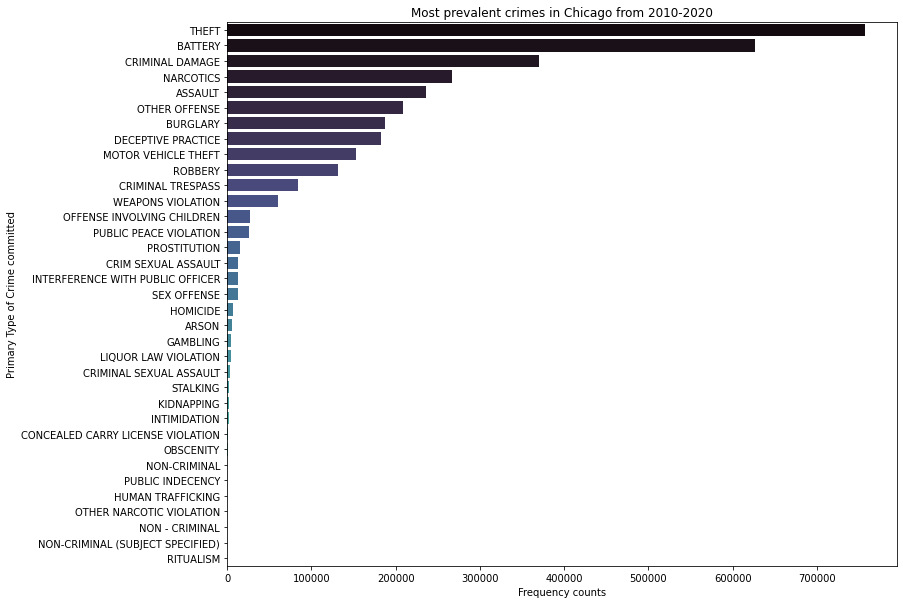

In [ ]:
plt.subplots(figsize=(12, 10))
ax = sns.barplot(x="count", y="Primary Type", data= prevalent_crimes_df, palette='mako')
ax.set_title('Most prevalent crimes in Chicago from 2010-2020')
ax.set_xlabel('Frequency counts')
ax.set_ylabel('Primary Type of Crime committed')
plt.show()

### (ii) Which year did Chicago face the most number of crimes?

In [ ]:
crime_rate_by_year = dataset.groupby('Year').count().sort('count', ascending=False)
crime_rate_by_year = crime_rate_by_year.toPandas()

In [ ]:
crime_rate_by_year

Year   count
0   2010  369800
1   2011  350902
2   2012  335096
3   2013  306317
4   2014  273601
5   2016  266476
6   2017  264142
7   2018  262824
8   2019  258144
9   2015  257773
10  2020  207426
11  2021  202346
12  2022   50664

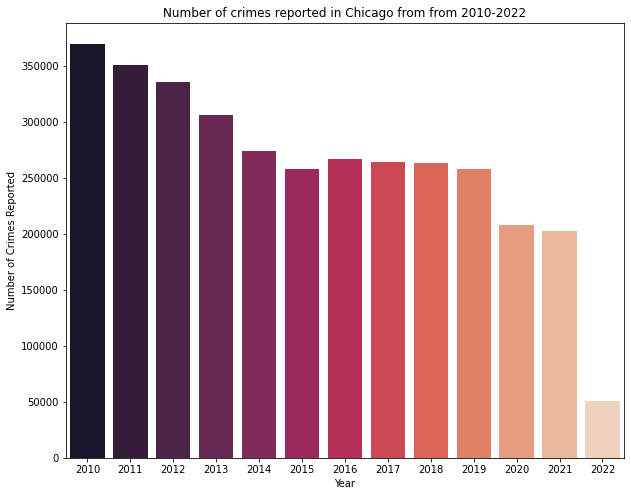

In [ ]:
plt.subplots(figsize=(10, 8))
ax = sns.barplot(x= "Year",y = "count", data= crime_rate_by_year, palette="rocket")
ax.set_title('Number of crimes reported in Chicago from from 2010-2022')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Crimes Reported')
plt.show()

### (iii) What percentage of arrests were successful in the last 10 years? What are the successful arrest percentages per year?

In [ ]:
successful_arrests = dataset.groupby('Arrest').count()
successful_arrests = successful_arrests.toPandas()

In [ ]:
successful_arrests

Arrest    count
0    True   798970
1   False  2606541

In [ ]:
arrest_per_year = dataset.groupby('Year','Arrest').count()
total_crimes_reported = dataset.groupby('Year').count()
cond = [total_crimes_reported['Year']==arrest_per_year['Year'], arrest_per_year['Arrest']==True]
arrests_data = total_crimes_reported.join(arrest_per_year, cond, 'inner').select(total_crimes_reported.Year.alias("Year"), ((arrest_per_year['count']/total_crimes_reported['count'])*100).alias("Percentage"))
arrests_data=arrests_data.toPandas()

In [ ]:
arrests_data

Year  Percentage
0   2018   20.133626
1   2014   28.980157
2   2019   21.706489
3   2016   19.828052
4   2020   16.251097
5   2012   27.025390
6   2013   28.219459
7   2015   26.185830
8   2011   27.406512
9   2010   27.165765
10  2017   19.779134
11  2021   12.194459
12  2022   12.105242

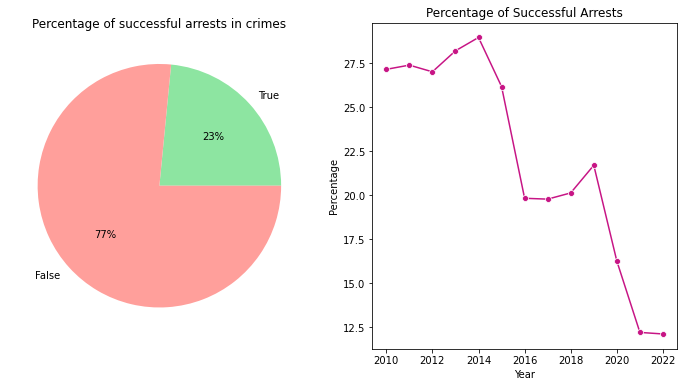

In [ ]:

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
colors = sns.color_palette('pastel')[2:4]
ax1.pie(successful_arrests['count'], labels=successful_arrests.Arrest, colors = colors, autopct = '%0.0f%%')
ax1.set_title('Percentage of successful arrests in crimes')

ax2=sns.lineplot(data=arrests_data, x="Year", y="Percentage",marker='o',color='mediumvioletred')
ax2.set_title('Percentage of Successful Arrests')
ax2.set_xlabel('Year')
ax2.set_ylabel('Percentage')

plt.show()


### (iv) Visuaising the Crime Hotspots in the city

In [ ]:
pandas_dataset = dataset.filter(dataset['Year']==2022).select('Latitude','Longitude','Primary Type').limit(1000).toPandas()

In [ ]:
pandas_dataset

Latitude  Longitude       Primary Type
0    41.756565 -87.616111    CRIMINAL DAMAGE
1    41.762045 -87.676517  CRIMINAL TRESPASS
2    41.847856 -87.645163            ROBBERY
3    41.758472 -87.563939              THEFT
4    41.812949 -87.710200              THEFT
..         ...        ...                ...
995  41.956252 -87.706865      OTHER OFFENSE
996  41.911052 -87.642702            BATTERY
997  41.947949 -87.657111              THEFT
998  41.886134 -87.668263            ROBBERY
999  41.885482 -87.627936            BATTERY

[1000 rows x 3 columns]

In [ ]:
chicago_map = folium.Map([41.8781, -87.6298], zoom_start=11)

for index, row in pandas_dataset.iterrows():
  folium.CircleMarker([row['Latitude'], row['Longitude']], 
                      radius=5, 
                      popup=row['Primary Type'],
                      fill_color = "#3db7e4",).add_to(chicago_map)

In [ ]:
stationArr = pandas_dataset[['Latitude','Longitude']].to_numpy()

chicago_map.add_children(plugins.HeatMap(stationArr, radius=5))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
chicago_map

### (v) Top 10 Crime Scenes

In [ ]:
location_desc = dataset.groupby('Location Description').count().sort('count', ascending=False).limit(10)
location_desc = location_desc.toPandas()
location_desc['Percentage'] = location_desc['count']/dataset_size * 100
location_desc

Location Description   count  Percentage
0                          STREET  794157   23.319760
1                       RESIDENCE  556605   16.344243
2                       APARTMENT  459440   13.491074
3                        SIDEWALK  334392    9.819143
4                           OTHER  112462    3.302353
5  PARKING LOT/GARAGE(NON.RESID.)   86221    2.531808
6              SMALL RETAIL STORE   73895    2.169865
7                           ALLEY   73314    2.152805
8                      RESTAURANT   64998    1.908612
9   RESIDENTIAL YARD (FRONT/BACK)   59023    1.733161

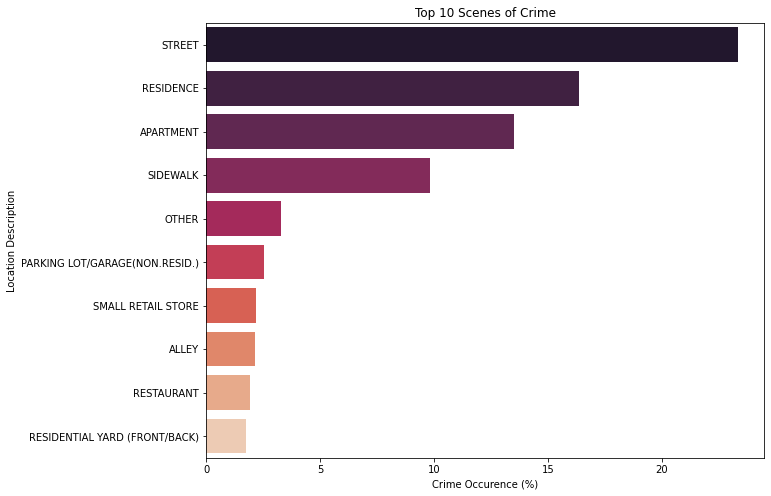

In [ ]:
plt.subplots(figsize=(10, 8))
ax = sns.barplot(y= "Location Description",x = "Percentage", data= location_desc, palette="rocket")
ax.set_title('Top 10 Scenes of Crime')
ax.set_ylabel('Location Description')
ax.set_xlabel('Crime Occurence (%)')
plt.show()

### (vi) Crime Occurence by Hour of the Day

In [ ]:
hour = dataset.groupby('Hour').count().sort('count')
hour = hour.toPandas()
hour['Percentage'] = hour['count']/dataset_size * 100

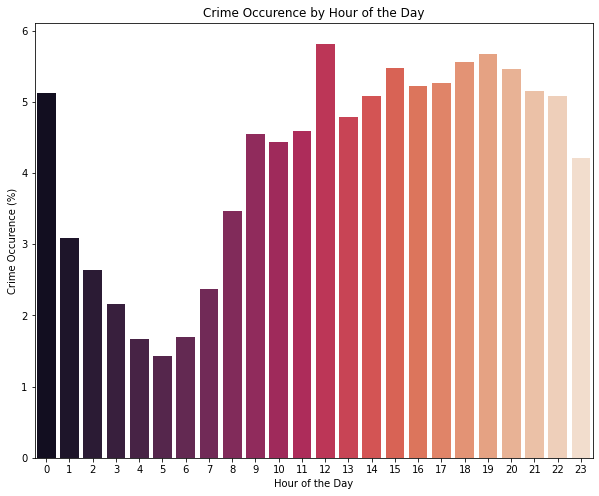

In [ ]:
plt.subplots(figsize=(10, 8))
ax = sns.barplot(x= "Hour",y = "Percentage", data= hour, palette="rocket")
ax.set_title('Crime Occurence by Hour of the Day')
ax.set_xlabel('Hour of the Day')
ax.set_ylabel('Crime Occurence (%)')
plt.show()

### (vii) Crime Occurence by Day of the Week 

In [ ]:
day = dataset.groupby('Day').count().sort('count')
day = day.toPandas()
day['Percentage'] = day['count']/dataset_size* 100

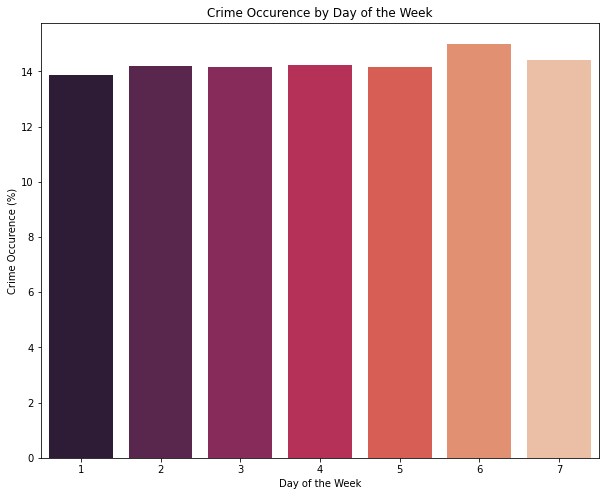

In [ ]:
plt.subplots(figsize=(10, 8))
ax = sns.barplot(x= "Day",y = "Percentage", data= day, palette="rocket")
ax.set_title('Crime Occurence by Day of the Week')
ax.set_xlabel('Day of the Week')
ax.set_ylabel('Crime Occurence (%)')
plt.show()

### (viii) Crime Occurence by Month

In [ ]:
month = dataset.groupby('Month').count().sort('count')
month = month.toPandas()
month['Percentage'] = month['count']/dataset_size* 100

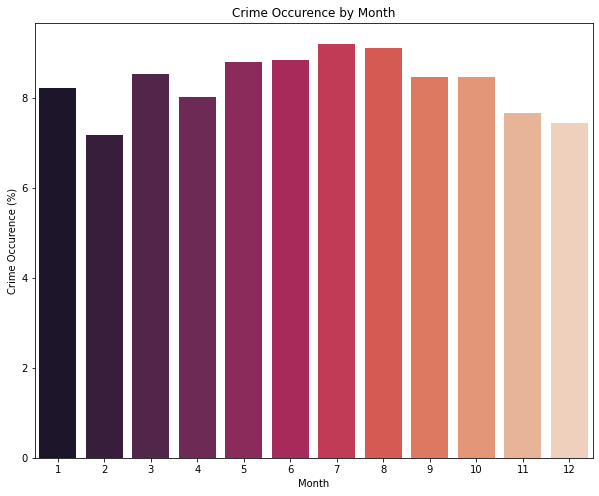

In [ ]:
plt.subplots(figsize=(10, 8))
ax = sns.barplot(x= "Month",y = "Percentage", data= month, palette="rocket")
ax.set_title('Crime Occurence by Month')
ax.set_xlabel('Month')
ax.set_ylabel('Crime Occurence (%)')
plt.show()

## Section 3 : Predictive Analysis

We want to predict if based on the location and time data we can predict the type of crime

### Data Preparation

In [ ]:
# make a copy of the data
ml_data_df = dataset.filter((dataset['Year'] >=2018) & (dataset['Year'] <=2022))

In [ ]:
ml_data_df.count()

981404

In [ ]:
pd_dataset = ml_data_df.toPandas()

In [ ]:
pd_dataset.to_csv (r'/content/gdrive/Shareddrives/CIS 545- Final Project/pandas_dataset.csv', index = None, header=True)

In [ ]:
pd_dataset = pd.read_csv('/content/gdrive/Shareddrives/CIS 545- Final Project/pandas_dataset.csv')  

In [ ]:
pd_dataset.head(3)

ID Case Number                 Date                 Block  IUCR  \
0  12014684    JD189901  2020-03-17 21:30:00  039XX N LECLAIRE AVE  0820   
1  11864018    JC476123  2019-09-24 08:00:00  022XX S MICHIGAN AVE  1154   
2  11859805    JC471592  2019-10-13 20:30:00   024XX W CHICAGO AVE  0860   

         Primary Type                              Description  \
0               THEFT                           $500 AND UNDER   
1  DECEPTIVE PRACTICE  FINANCIAL IDENTITY THEFT $300 AND UNDER   
2               THEFT                             RETAIL THEFT   

           Location Description  Arrest  Domestic  ...  FBI Code  \
0                        STREET   False     False  ...        06   
1  COMMERCIAL / BUSINESS OFFICE   False     False  ...        11   
2            GROCERY FOOD STORE   False     False  ...        06   

   X Coordinate  Y Coordinate  Year   Latitude  Longitude  \
0     1141659.0     1925649.0  2020  41.952052 -87.754660   
1     1177560.0     1889548.0  2019  41.852248 -87.623786   
2     1160005.0     1905256.0  2019  41.895732 -87.687784   

                        Location  Day  Month  Hour  
0  (41.952051946, -87.754660372)    3      3    21  
1  (41.852248185, -87.623786256)    3      9     8  
2  (41.895732399, -87.687784384)    1     10    20  

[3 rows x 24 columns]

**Dropping irrelavent columns**

We do not require columns like ID and Case Number for our predictive analysis, so we drop them. We also drop columns like IUCR, FBI Code, Description (They give information about the crime type which is what we are trying to predict). We also drop 'Location' since it gives the Latitude and Longitude which are other features.

In [ ]:
pd_dataset = pd_dataset.drop(['ID', 'Case Number', 'IUCR', 'Description', 'FBI Code', 'Location'], axis=1)

pd_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981404 entries, 0 to 981403
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Date                  981404 non-null  object 
 1   Block                 981404 non-null  object 
 2   Primary Type          981404 non-null  object 
 3   Location Description  981404 non-null  object 
 4   Arrest                981404 non-null  bool   
 5   Domestic              981404 non-null  bool   
 6   Beat                  981404 non-null  int64  
 7   District              981404 non-null  int64  
 8   Ward                  981404 non-null  int64  
 9   Community Area        981404 non-null  int64  
 10  X Coordinate          981404 non-null  float64
 11  Y Coordinate          981404 non-null  float64
 12  Year                  981404 non-null  int64  
 13  Latitude              981404 non-null  float64
 14  Longitude             981404 non-null  float64
 15  

In [ ]:
# Adding Minute and Second columns
pd_dataset['Date'] = pd.to_datetime(pd_dataset['Date'])
pd_dataset['Minute'] = pd_dataset['Date'].dt.minute
pd_dataset['Second'] = pd_dataset['Date'].dt.second 
pd_dataset = pd_dataset.drop(['Date'], axis=1) 

pd_dataset.head(5)

Block         Primary Type          Location Description  \
0  039XX N LECLAIRE AVE                THEFT                        STREET   
1  022XX S MICHIGAN AVE   DECEPTIVE PRACTICE  COMMERCIAL / BUSINESS OFFICE   
2   024XX W CHICAGO AVE                THEFT            GROCERY FOOD STORE   
3  039XX W JACKSON BLVD  MOTOR VEHICLE THEFT                     APARTMENT   
4     0000X N LOOMIS ST                THEFT                     RESIDENCE   

   Arrest  Domestic  Beat  District  Ward  Community Area  X Coordinate  \
0   False     False  1634        16    45              15     1141659.0   
1   False     False   132         1     3              33     1177560.0   
2   False     False  1221        12    26              24     1160005.0   
3   False      True  1132        11    28              26     1150196.0   
4   False     False  1224        12    27              28     1166986.0   

   Y Coordinate  Year   Latitude  Longitude  Day  Month  Hour  Minute  Second  
0     1925649.0  2020  41.952052 -87.754660    3      3    21      30       0  
1     1889548.0  2019  41.852248 -87.623786    3      9     8       0       0  
2     1905256.0  2019  41.895732 -87.687784    1     10    20      30       0  
3     1898398.0  2020  41.877110 -87.723990    4      3     2       3       0  
4     1900306.0  2019  41.882002 -87.662287    7     10    18      30       0

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
pd_dataset['Block'] = labelencoder.fit_transform(pd_dataset['Block'])
pd_dataset['Location Description'] = labelencoder.fit_transform(pd_dataset['Location Description'])

In [ ]:
pd_dataset.head(5)

Block         Primary Type  Location Description  Arrest  Domestic  Beat  \
0  18060                THEFT                   159   False     False  1634   
1  11182   DECEPTIVE PRACTICE                    55   False     False   132   
2  12179                THEFT                    90   False     False  1221   
3  18331  MOTOR VEHICLE THEFT                    19   False      True  1132   
4    259                THEFT                   134   False     False  1224   

   District  Ward  Community Area  X Coordinate  Y Coordinate  Year  \
0        16    45              15     1141659.0     1925649.0  2020   
1         1     3              33     1177560.0     1889548.0  2019   
2        12    26              24     1160005.0     1905256.0  2019   
3        11    28              26     1150196.0     1898398.0  2020   
4        12    27              28     1166986.0     1900306.0  2019   

    Latitude  Longitude  Day  Month  Hour  Minute  Second  
0  41.952052 -87.754660    3      3    21      30       0  
1  41.852248 -87.623786    3      9     8       0       0  
2  41.895732 -87.687784    1     10    20      30       0  
3  41.877110 -87.723990    4      3     2       3       0  
4  41.882002 -87.662287    7     10    18      30       0

In [ ]:
Target = 'Primary Type'

When we refer to visualisation 2.1 we see that there is a lot of class imbalance, so we can group less occuring crime types into a single category called "Others" for the purpose of our predictive analysis.

In [ ]:
# Checking the occurence of each crime tyoe
all_crimes = pd_dataset.groupby(['Primary Type'])['Block'].size().reset_index()
all_crimes['Number'] = all_crimes['Block']
all_crimes = all_crimes.drop(['Block'], axis=1)
all_crimes = all_crimes.sort_values(['Number'], ascending=[False])

# we can select the less occuring crimes as a single type and merge it with the Pimary Type "OTHER OFFENSE"
other_classes = all_crimes.tail(15)
other_classes

Primary Type  Number
0                               ARSON    1940
25                       PROSTITUTION    1840
31                           STALKING    1057
16               LIQUOR LAW VIOLATION     852
4   CONCEALED CARRY LICENSE VIOLATION     732
14                       INTIMIDATION     646
15                         KIDNAPPING     572
10                           GAMBLING     382
21                          OBSCENITY     250
12                  HUMAN TRAFFICKING      48
19                       NON-CRIMINAL      44
26                   PUBLIC INDECENCY      38
23           OTHER NARCOTIC VIOLATION      16
20   NON-CRIMINAL (SUBJECT SPECIFIED)       3
28                          RITUALISM       1

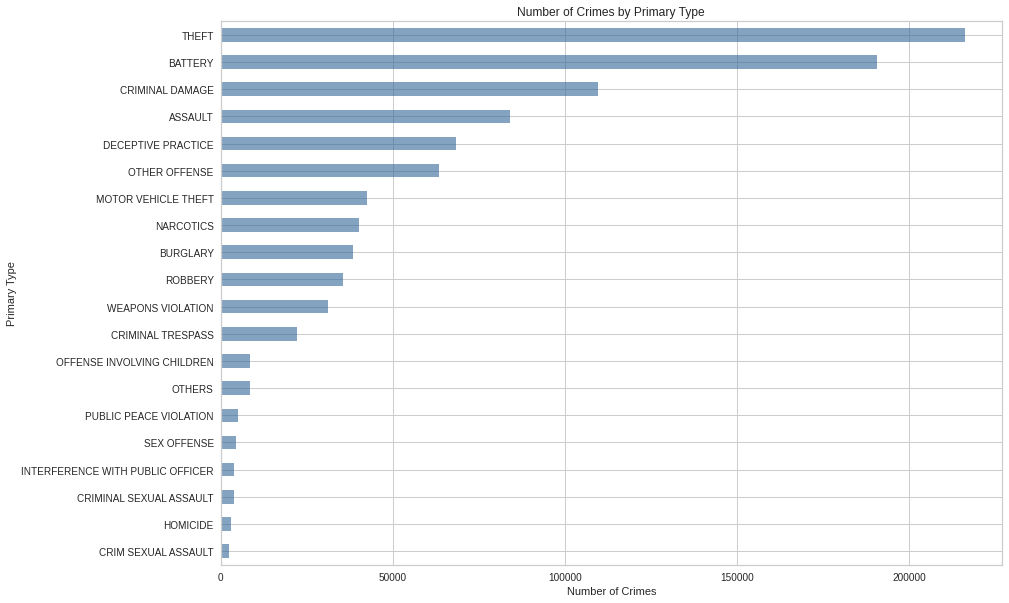

In [ ]:
# Adding "Other" label to the dataset
pd_dataset.loc[pd_dataset['Primary Type'].isin(other_classes['Primary Type']), 'Primary Type'] = 'OTHERS'

plt.figure(figsize=(14,10))
plt.title('Number of Crimes by Primary Type')
plt.ylabel('Crime Type')
plt.xlabel('Number of Crimes')

pd_dataset.groupby([pd_dataset['Primary Type']]).size().sort_values(ascending=True).plot(kind='barh', color=(0.2, 0.4, 0.6, 0.6))

plt.show()

In [ ]:
pd_dataset.loc[pd_dataset["Primary Type"] == "CRIM SEXUAL ASSAULT", "Primary Type"] = "CRIMINAL SEXUAL ASSAULT"

In [ ]:
Classes = pd_dataset['Primary Type'].unique()
Classes

array(['THEFT', 'DECEPTIVE PRACTICE', 'MOTOR VEHICLE THEFT',
       'CRIMINAL DAMAGE', 'ASSAULT', 'BATTERY', 'OTHER OFFENSE',
       'NARCOTICS', 'WEAPONS VIOLATION', 'ROBBERY', 'CRIMINAL TRESPASS',
       'BURGLARY', 'INTERFERENCE WITH PUBLIC OFFICER', 'OTHERS',
       'CRIMINAL SEXUAL ASSAULT', 'OFFENSE INVOLVING CHILDREN',
       'PUBLIC PEACE VIOLATION', 'SEX OFFENSE', 'HOMICIDE'], dtype=object)

In [ ]:
#Encode target labels into categorical variables
pd_dataset['Primary Type'] = pd.factorize(pd_dataset["Primary Type"])[0] 
pd_dataset['Primary Type'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18])

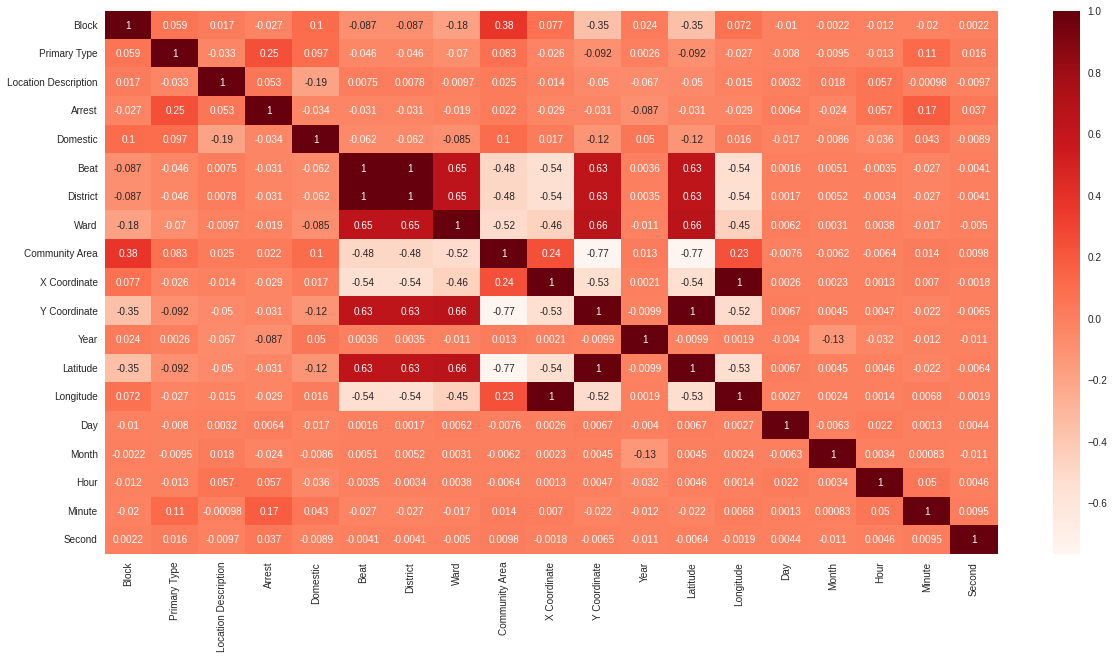

In [ ]:
# Split Dataframe to target class and features
X = pd_dataset.drop(['Primary Type'], axis=1)
Y = pd_dataset['Primary Type']

# Pearson Correlation
plt.figure(figsize=(20,10))
cor = pd_dataset.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

**Interpretation of Correlation Values**

The correlation coefficient has values between -1 to 1. A value closer to 0 implies weaker correlation. A value of 0 means no correlation. A value closer to 1 implies stronger positive correlation and a value closer to -1 implies stronger negative correlation. For the purpose of this project we are using all Location and time based features to see if we can predict crime based on that data. As future scope and if we have more predictive data like economic and demographic data we can select features which are positively correlated.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Size of Training dataset: ", X_train.shape)
print("Size of Test dataset: ", X_test.shape)

Size of Training dataset:  (785123, 18)
Size of Test dataset:  (196281, 18)


### Random Forest Classifier

In [ ]:
model1 = RandomForestClassifier(n_estimators=50, # Number of trees
                                  min_samples_split = 20,
                                  bootstrap = True, 
                                  max_depth = 20, 
                                  min_samples_leaf = 25)

# Model Training
model1.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=25, min_samples_split=20,
                       n_estimators=50)

In [ ]:
preds= model1.predict(X_test)

In [ ]:
# Model Evaluation
accuracy_model1 = accuracy_score(y_test, preds)
recall_model1 = recall_score(y_test, preds, average="weighted")
precision_model1 = precision_score(y_test, preds, average="weighted")
f1_model1 = f1_score(y_test, preds, average='micro')
cm_model1 = confusion_matrix(y_test, preds)

print("Accuracy: ", accuracy_model1)
print("Recall: ", recall_model1)
print("Precision: ", precision_model1)
print("F1 Score: ", f1_model1)

Accuracy:  0.4111401511098884
Recall:  0.4111401511098884
Precision:  0.38320316403099913
F1 Score:  0.4111401511098884


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(99.0, 0.5, 'True Label')

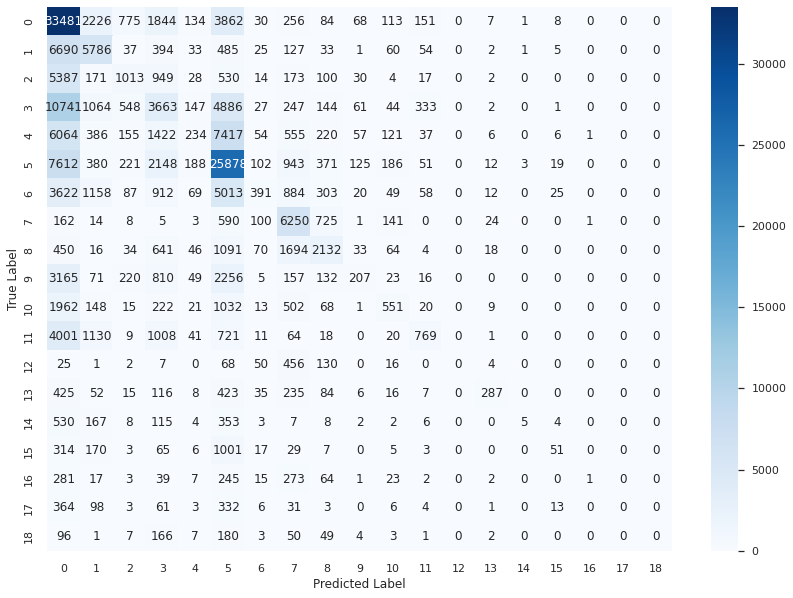

In [ ]:
sns.set(rc = {'figure.figsize':(14,10)})
plt = sns.heatmap(cm_model1, annot=True, cmap="Blues", fmt='g')
plt.set_xlabel("Predicted Label")
plt.set_ylabel("True Label")

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


================= Classification Report =================



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                  precision    recall  f1-score   support

                           THEFT       0.39      0.78      0.52     43040
              DECEPTIVE PRACTICE       0.44      0.42      0.43     13733
             MOTOR VEHICLE THEFT       0.32      0.12      0.17      8418
                 CRIMINAL DAMAGE       0.25      0.17      0.20     21908
                         ASSAULT       0.23      0.01      0.03     16735
                         BATTERY       0.46      0.68      0.55     38239
                   OTHER OFFENSE       0.40      0.03      0.06     12603
                       NARCOTICS       0.48      0.78      0.60      8024
               WEAPONS VIOLATION       0.46      0.34      0.39      6293
                         ROBBERY       0.34      0.03      0.05      7111
               CRIMINAL TRESPASS       0.38      0.12      0.18      4564
                        BURGLARY       0.50      0.10      0.16      7793
INTERFERENCE WITH PUBLIC OFFICER     

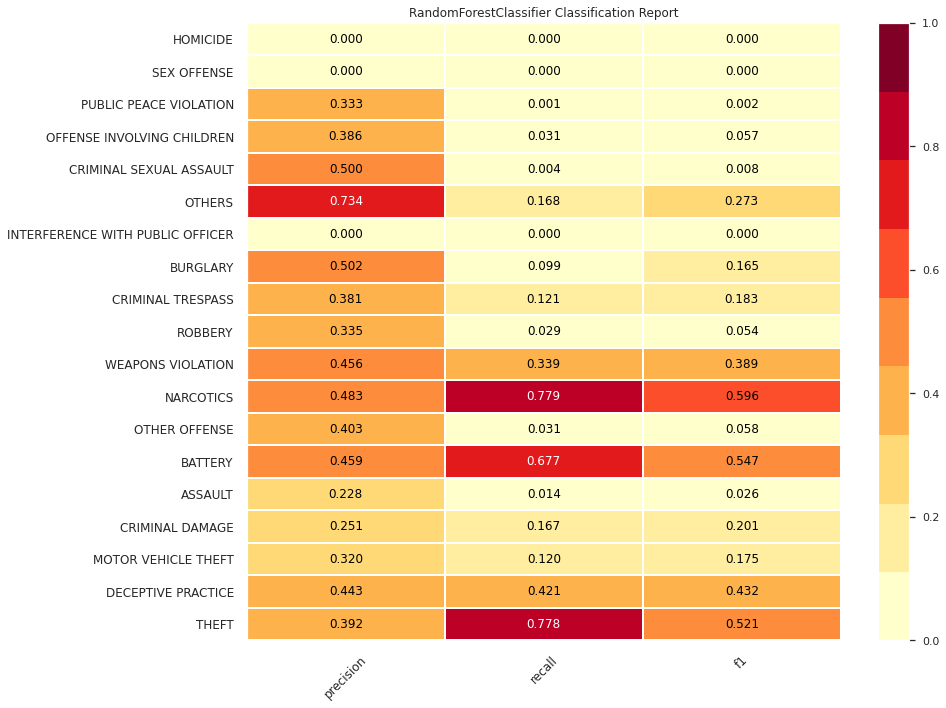

In [ ]:
target_names = Classes
visualizer = ClassificationReport(model1, classes=target_names)
visualizer.fit(X_train, y_train)     # Fit the training data to the visualizer
visualizer.score(X_test, y_test)       # Evaluate the model on the test data

print('================= Classification Report =================')
print('')
print(classification_report(y_test, preds, target_names=target_names))

g = visualizer.poof()             # Draw/show/poof the data

### KNN Classifier

In [ ]:
model2 = KNeighborsClassifier(n_neighbors=3)

# Model Training
model2.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
preds= model2.predict(X_test)

In [ ]:
# Model Evaluation
accuracy_model2 = accuracy_score(y_test, preds)
recall_model2 = recall_score(y_test, preds, average="weighted")
precision_model2 = precision_score(y_test, preds, average="weighted")
f1_model2 = f1_score(y_test, preds, average='micro')
cm_model2 = confusion_matrix(y_test, preds)

print("Accuracy: ", accuracy_model2)
print("Recall: ", recall_model2)
print("Precision: ", precision_model2)
print("F1 Score: ", f1_model2)

Accuracy:  0.25549594713701274
Recall:  0.25549594713701274
Precision:  0.23762365563507706
F1 Score:  0.25549594713701274


Text(99.0, 0.5, 'True Label')

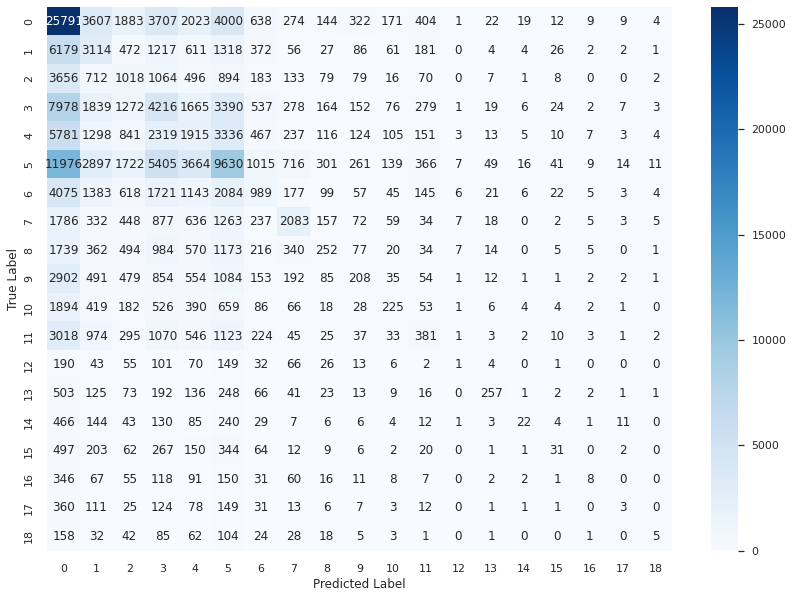

In [ ]:
sns.set(rc = {'figure.figsize':(14,10)})
plt = sns.heatmap(cm_model2, annot=True, cmap="Blues", fmt='g')
plt.set_xlabel("Predicted Label")
plt.set_ylabel("True Label")

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


================= Classification Report =================

                                  precision    recall  f1-score   support

                           THEFT       0.33      0.60      0.42     43040
              DECEPTIVE PRACTICE       0.17      0.23      0.20     13733
             MOTOR VEHICLE THEFT       0.10      0.12      0.11      8418
                 CRIMINAL DAMAGE       0.17      0.19      0.18     21908
                         ASSAULT       0.13      0.11      0.12     16735
                         BATTERY       0.31      0.25      0.28     38239
                   OTHER OFFENSE       0.18      0.08      0.11     12603
                       NARCOTICS       0.43      0.26      0.32      8024
               WEAPONS VIOLATION       0.16      0.04      0.06      6293
                         ROBBERY       0.13      0.03      0.05      7111
               CRIMINAL TRESPASS       0.22      0.05      0.08      4564
                        BURGLARY       0.17      0.0

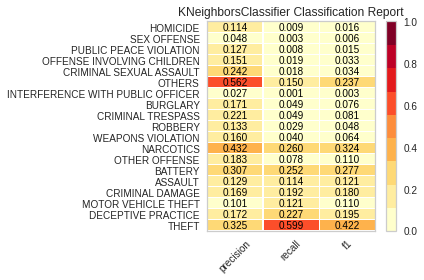

In [ ]:
target_names = Classes
visualizer = ClassificationReport(model2, classes=target_names)
visualizer.fit(X_train, y_train)     # Fit the training data to the visualizer
visualizer.score(X_test, y_test)       # Evaluate the model on the test data

print('================= Classification Report =================')
print('')
print(classification_report(y_test, preds, target_names=target_names))

g = visualizer.poof()             # Draw/show/poof the data

### Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
model3 = DecisionTreeClassifier()

model3.fit(X_train, y_train)

DecisionTreeClassifier()

In [ ]:
preds= model3.predict(X_test)

In [ ]:
# Model Evaluation
accuracy_model3 = accuracy_score(y_test, preds)
recall_model3 = recall_score(y_test, preds, average="weighted")
precision_model3 = precision_score(y_test, preds, average="weighted")
f1_model3 = f1_score(y_test, preds, average='micro')
cm_model3 = confusion_matrix(y_test, preds)

print("Accuracy: ", accuracy_model3)
print("Recall: ", recall_model3)
print("Precision: ", precision_model3)
print("F1 Score: ", f1_model3)

Accuracy:  0.2957494612316016
Recall:  0.2957494612316016
Precision:  0.2986457627241167
F1 Score:  0.2957494612316016


Text(99.0, 0.5, 'True Label')

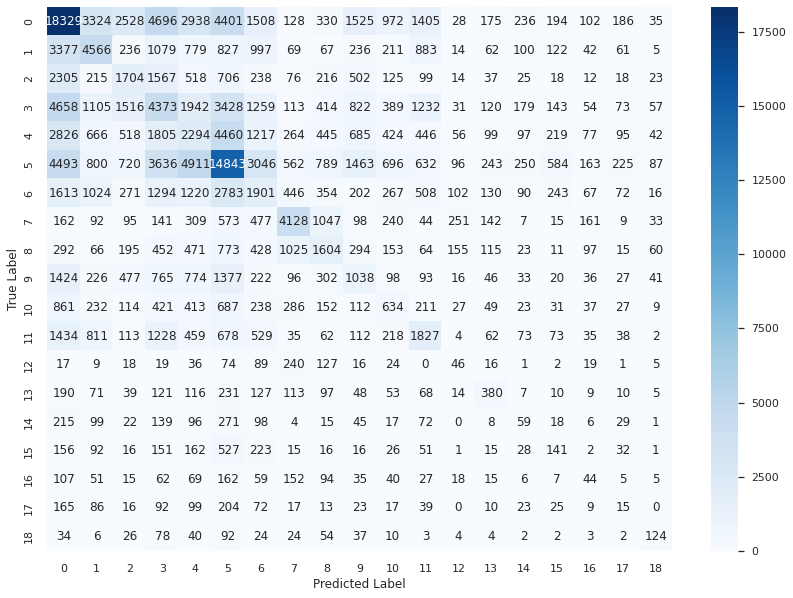

In [ ]:
sns.set(rc = {'figure.figsize':(14,10)})
plt = sns.heatmap(cm_model3, annot=True, cmap="Blues", fmt='g')
plt.set_xlabel("Predicted Label")
plt.set_ylabel("True Label")

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"


================= Classification Report =================

                                  precision    recall  f1-score   support

                           THEFT       0.43      0.43      0.43     43040
              DECEPTIVE PRACTICE       0.34      0.33      0.33     13733
             MOTOR VEHICLE THEFT       0.20      0.20      0.20      8418
                 CRIMINAL DAMAGE       0.20      0.20      0.20     21908
                         ASSAULT       0.13      0.14      0.13     16735
                         BATTERY       0.40      0.39      0.39     38239
                   OTHER OFFENSE       0.15      0.15      0.15     12603
                       NARCOTICS       0.53      0.51      0.52      8024
               WEAPONS VIOLATION       0.26      0.25      0.26      6293
                         ROBBERY       0.14      0.15      0.14      7111
               CRIMINAL TRESPASS       0.14      0.14      0.14      4564
                        BURGLARY       0.24      0.2

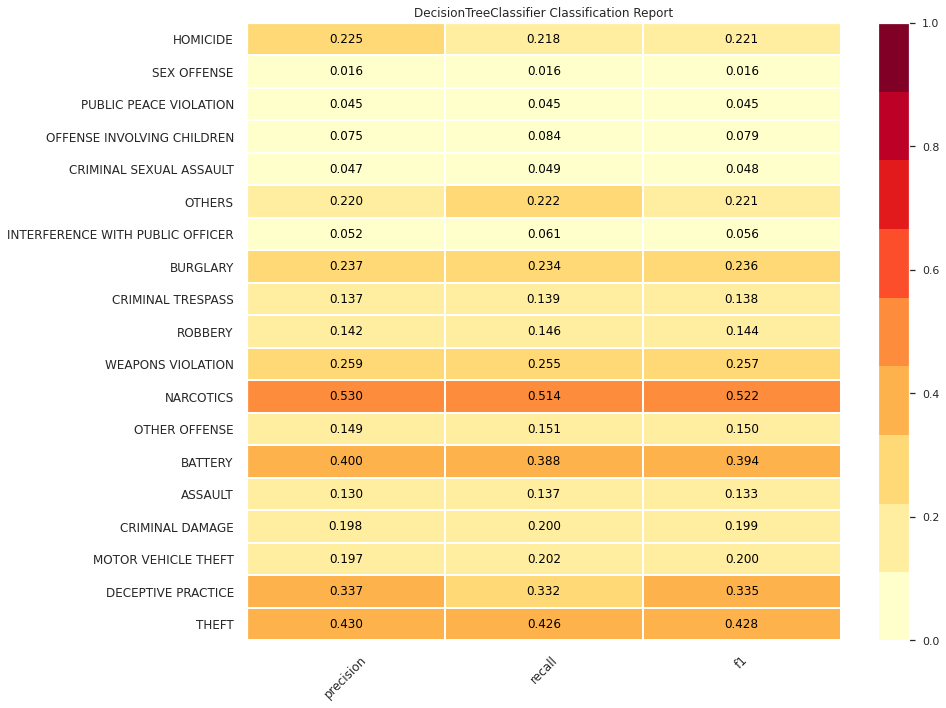

In [ ]:
target_names = Classes
visualizer = ClassificationReport(model3, classes=target_names)
visualizer.fit(X_train, y_train)     # Fit the training data to the visualizer
visualizer.score(X_test, y_test)       # Evaluate the model on the test data

print('================= Classification Report =================')
print('')
print(classification_report(y_test, preds, target_names=target_names))

g = visualizer.poof()             # Draw/show/poof the data

### Voting Ensemble

In [ ]:
model4 = VotingClassifier(estimators=[('rf', model1), ('knn', model2) , ('dt', model3)], 
                         weights=[1,1,1],
                         flatten_transform=True)
model4 = model4.fit(X_train, y_train)   

preds = model4.predict(X_test)

In [ ]:
# Model Evaluation
accuracy_model4 = accuracy_score(y_test, preds)
recall_model4 = recall_score(y_test, preds, average="weighted")
precision_model4 = precision_score(y_test, preds, average="weighted")
f1_model4 = f1_score(y_test, preds, average='micro')
cm_model4 = confusion_matrix(y_test, preds)

print("Accuracy: ", accuracy_model4)
print("Recall: ", recall_model4)
print("Precision: ", precision_model4)
print("F1 Score: ", f1_model4)

Accuracy:  0.3550369113668669
Recall:  0.3550369113668669
Precision:  0.3572798012456487
F1 Score:  0.35503691136686694


Text(99.0, 0.5, 'True Label')

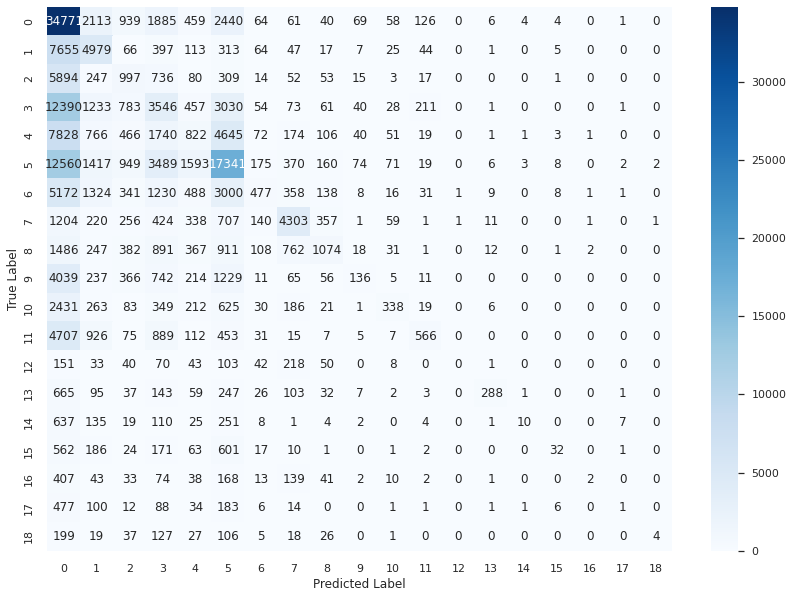

In [ ]:
sns.set(rc = {'figure.figsize':(14,10)})
plt = sns.heatmap(cm_model4, annot=True, cmap="Blues", fmt='g')
plt.set_xlabel("Predicted Label")
plt.set_ylabel("True Label")

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


================= Classification Report =================

                                  precision    recall  f1-score   support

                           THEFT       0.34      0.81      0.48     43040
              DECEPTIVE PRACTICE       0.34      0.36      0.35     13733
             MOTOR VEHICLE THEFT       0.17      0.12      0.14      8418
                 CRIMINAL DAMAGE       0.21      0.16      0.18     21908
                         ASSAULT       0.15      0.05      0.07     16735
                         BATTERY       0.47      0.45      0.46     38239
                   OTHER OFFENSE       0.35      0.04      0.07     12603
                       NARCOTICS       0.62      0.54      0.57      8024
               WEAPONS VIOLATION       0.48      0.17      0.25      6293
                         ROBBERY       0.32      0.02      0.04      7111
               CRIMINAL TRESPASS       0.47      0.07      0.13      4564
                        BURGLARY       0.53      0.0

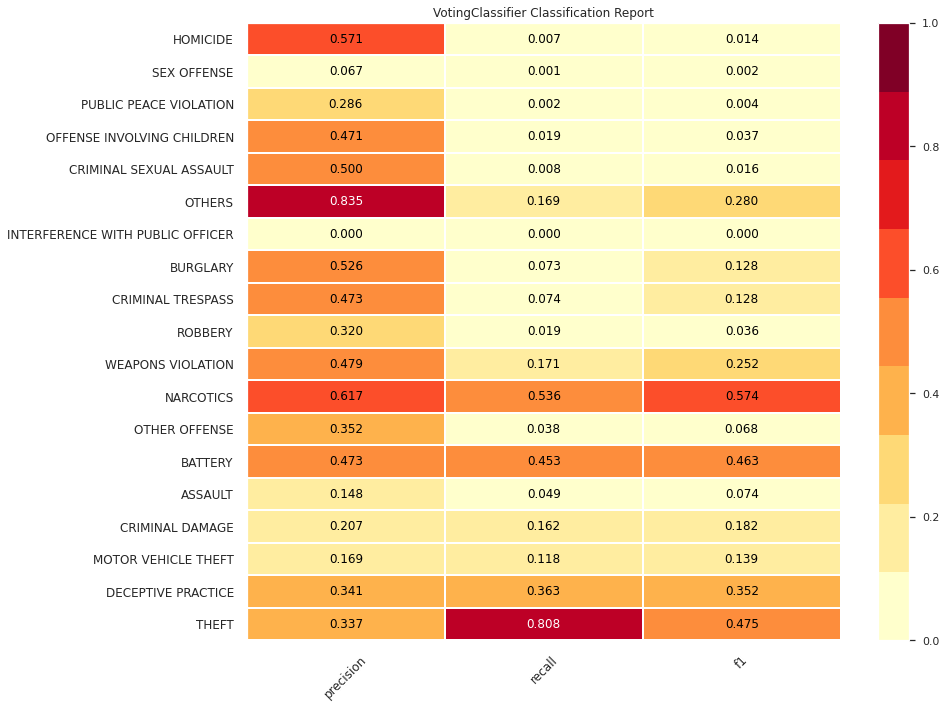

In [ ]:
target_names = Classes
visualizer = ClassificationReport(model4, classes=target_names)
visualizer.fit(X_train, y_train)     
visualizer.score(X_test, y_test)       

print('================= Classification Report =================')
print('')
print(classification_report(y_test, preds, target_names=target_names))

g = visualizer.poof()             